**COVID-19 detection with Heat-map visualization**

In [1]:
    from google.colab import drive
    drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
    import zipfile

    zip_path = '/content/drive/MyDrive/Colab Notebooks/Sanjana.zip' # Replace with the actual path

    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall('/content/') # Replace with desired extraction path

In [3]:
!pip install opencv-python
import os
import sys
import random
import subprocess
import cv2 #After installation, this line should work

import numpy as np
import pandas as pd
from sklearn.preprocessing import OneHotEncoder
from collections import OrderedDict

import scipy
import scipy.ndimage as ndimage
import scipy.ndimage.filters as filters
from scipy.ndimage import binary_dilation
import matplotlib.patches as patches

import torch
import torch.nn as nn
import torch.backends.cudnn as cudnn
from torch.nn import functional as F
import torchvision
import torchvision.transforms as transforms
from torch.autograd import Variable
from sklearn.metrics import roc_auc_score
import torch.optim as optim
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data import Dataset

from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
from PIL import Image

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.0/63.0 MB 20.4 MB/s eta 0:00:00


In [4]:
random_seed= 42
np.random.seed(random_seed)
torch.manual_seed(random_seed)
torch.cuda.manual_seed(random_seed)
torch.backends.cudnn.deterministic=True
torch.backends.cudnn.benchmark = True
batch_size = 64
validation_split = .34
shuffle_dataset = True

In [5]:
def run_cmd(cmd, stderr=subprocess.STDOUT):
    out = None
    try:
        out = subprocess.check_output(
            [cmd],
            shell=True,
            stderr=subprocess.STDOUT,
            universal_newlines=True,
        )
    except subprocess.CalledProcessError as e:
        print(f'ERROR {e.returncode}: {cmd}\n\t{e.output}', flush=True, file=sys.stderr)
        raise e
    return out

In [6]:
def clone_data(data_root):
    clone_uri = 'https://github.com/ieee8023/covid-chestxray-dataset.git'
    if os.path.exists(data_root):
        assert os.path.isdir(data_root), \
        f'{data_root} should be cloned from {clone_uri}'
    else:
        print(
            'Cloning the covid chestxray dataset. It may take a while\n...\n',
            flush=True
        )
        run_cmd(f'git clone {clone_uri} {data_root}')

In [7]:
data_root = "./data"
mgpath=f'{data_root}/images',
csvpath=f'{data_root}//content/metadata.csv',

In [8]:
csvpath


('./data//content/metadata.csv',)

In [9]:
clone_data(data_root)


Cloning the covid chestxray dataset. It may take a while
...



In [10]:
meta = pd.read_csv('/content/metadata.csv')

In [11]:
meta['view'].value_counts(dropna=False)


view
PA               195
AP                58
AP Supine         45
Axial             41
L                 29
Coronal            3
AP semi erect      1
Name: count, dtype: int64

In [12]:
for x in meta['filename']:
    if x.split('.')[-1]=='gz':
        meta.drop(meta.index[meta['filename']==x],
                  inplace=True)

In [13]:
meta = meta[(meta['finding']=='COVID-19')
            |(meta['finding']=='SARS')
            |(meta['finding']=='Pneumocystis')
            |(meta['finding']=='Streptococcus')
            |(meta['finding']=='COVID-19, ARDS')
            |(meta['finding']=='ARDS')]
meta = meta[meta['view']=='PA']

In [14]:
meta['finding'].value_counts(dropna=False)

finding
COVID-19          141
Streptococcus      13
Pneumocystis       12
COVID-19, ARDS     11
SARS                8
ARDS                4
Name: count, dtype: int64

In [15]:
X_train_val, features_test = train_test_split( meta[meta['finding']=='COVID-19'], test_size=0.85, random_state=random_seed)
meta.drop(features_test.index, inplace=True)
meta.reset_index(drop=True, inplace=True)

In [16]:
meta['finding'].value_counts(dropna=False)

finding
COVID-19          21
Streptococcus     13
Pneumocystis      12
COVID-19, ARDS    11
SARS               8
ARDS               4
Name: count, dtype: int64

In [17]:
dataset_size = len(meta)
indices = list(range(dataset_size))
split = int(np.floor(validation_split * dataset_size))
if shuffle_dataset :
    np.random.seed(random_seed)
    np.random.shuffle(indices)
train_indices, val_indices = indices[split:], indices[:split]

In [18]:
train_sampler = SubsetRandomSampler(train_indices)
valid_sampler = SubsetRandomSampler(val_indices)

In [19]:
Labels = np.array(meta['finding']).reshape(len(meta['finding']),1)
encode = OneHotEncoder()
encode.fit(Labels)
labels_enc = encode.transform(Labels).toarray()

In [20]:
transform=transforms.Compose([
                              transforms.ToPILImage(),
                              transforms.RandomCrop(224),
                              transforms.ToTensor(),
                              transforms.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])
                                        ])

In [21]:
class_names = [
    'COVID-19',
    'SARS ',
    'Pneumocystis',
    'Streptococcus',
    'COVID-19, ARDS',
    'ARDS',
]

In [22]:
class ChestXrayDataSet(Dataset):
    def __init__(self,csvpath,mgpath,labels_enc,transform=None):
        self.meta_data = pd.read_csv(csvpath)
        self.root_dir = mgpath
        self.labels = self.meta_data['finding']
        self.transform = transform
        for x in self.meta_data['filename']:
            if x.split('.')[-1]=='gz':
                self.meta_data.drop(self.meta_data.index[self.meta_data['filename']==x],
                                    inplace=True)

        self.meta_data = self.meta_data[(self.meta_data['finding']=='COVID-19')
                                        |(self.meta_data['finding']=='SARS')
                                        |(self.meta_data['finding']=='Pneumocystis')
                                        |(self.meta_data['finding']=='Streptococcus')
                                        |(self.meta_data['finding']=='COVID-19, ARDS')
                                        |(self.meta_data['finding']=='ARDS')]
        self.meta_data = self.meta_data[self.meta_data['view']=='PA']
        self.meta_data.drop(features_test.index, inplace=True)
        self.meta_data.reset_index(drop=True, inplace=True)

    def __len__(self):
        return len(self.meta_data)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        img_name = os.path.join(self.root_dir,
                                self.meta_data.loc[idx,'filename'])
        image = Image.open(img_name).convert('RGB')
        image = np.array(image.resize((256,256)))
        image = image[:,:,0]
        image = np.uint8(((np.array(image)/255).reshape(256,256,1))*255*255)
        image = np.tile(image,3)
        label = labels_enc[idx]
        if self.transform is not None:
            image = self.transform(image)
        return image, label, idx

In [23]:
dataset = ChestXrayDataSet('/content/metadata.csv',mgpath[0],labels_enc,transform)

In [24]:
train_loader = torch.utils.data.DataLoader(dataset,
                                           batch_size=batch_size,
                                           sampler=train_sampler)
validation_loader = torch.utils.data.DataLoader(dataset,
                                                batch_size=batch_size,
                                                sampler=valid_sampler)

In [25]:
def img_display(img):
    img = img*0.229+0.485   # unnormalize (inp = inp*std + mean)
    npimg = img.numpy()[0]

    return npimg

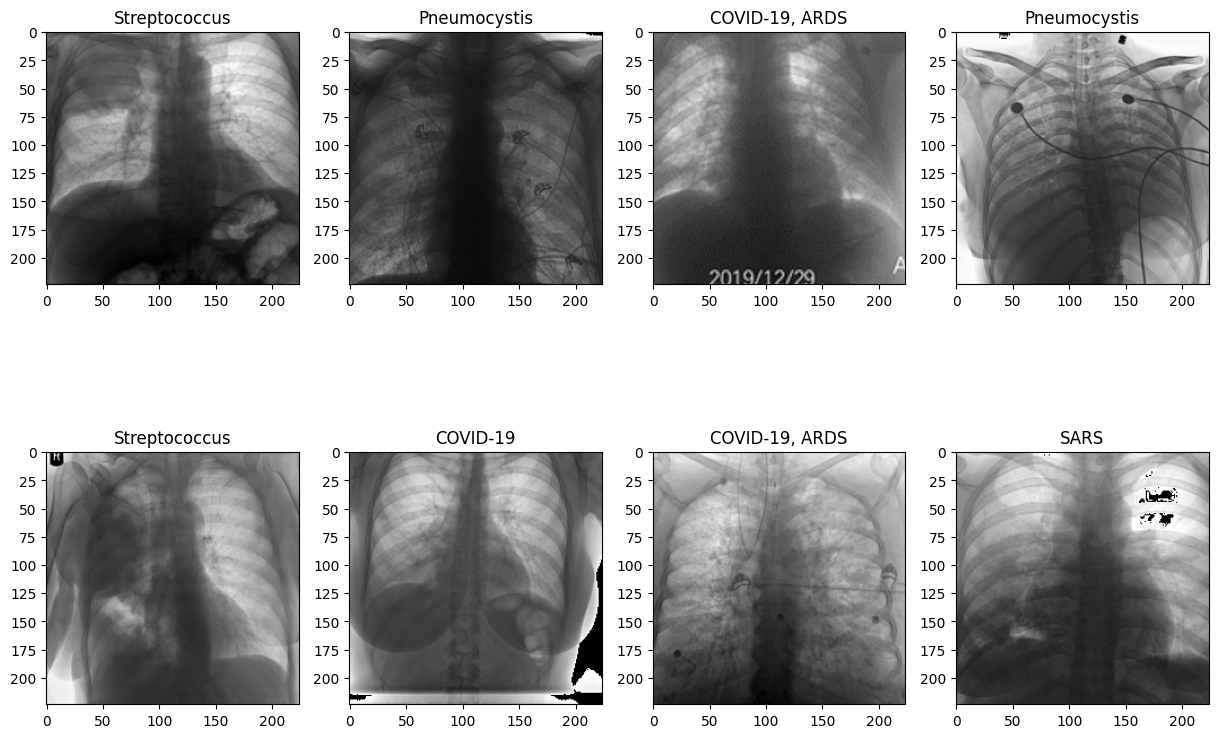

In [26]:
# get some random training images
dataiter = iter(train_loader)
images, labels, id_ = next(dataiter) # Use next(dataiter) instead of dataiter.next()
# Viewing data examples used for training
fig, axis = plt.subplots(2, 4, figsize=(15, 10))
for i, ax in enumerate(axis.flat):
    with torch.no_grad():
        image, label, _ = images[i], labels[i], id_[i]
        ax.imshow(img_display(image),cmap='gray') # add image
        ax.set(title = f"{meta['finding'][_.item()]}") # add label

In [27]:
# construct model
class DenseNet121(nn.Module):
    def __init__(self, out_size):
        super(DenseNet121, self).__init__()
        self.densenet121 = torchvision.models.densenet121(pretrained=True)
        num_ftrs = self.densenet121.classifier.in_features
        self.densenet121.classifier = nn.Sequential(
            nn.Linear(num_ftrs, out_size),
            nn.Sigmoid() #This activation function is for multi-label classification
        ).cuda()
    def forward(self, x):
        x = self.densenet121(x)
        return x

In [28]:
import torch
import torch.nn as nn
import torchvision.models as models

cudnn.benchmark = True
N_CLASSES = 6

In [29]:
def compute_AUCs(gt, pred):
    AUROCs = []
    gt_np = gt.cpu().numpy()
    pred_np = pred.cpu().numpy()
    for i in range(N_CLASSES):
        AUROCs.append(roc_auc_score(gt_np[:, i], pred_np[:, i]))
    return AUROCs

In [30]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cpu


In [31]:
base_model = models.densenet121(pretrained=True)

# Modify the classifier for your number of output classes
# DenseNet121 uses a classifier as the final fully connected layer
num_ftrs = base_model.classifier.in_features
base_model.classifier = nn.Linear(num_ftrs, N_CLASSES)

# Send the model to the selected device
model = base_model.to(device)

# Print model summary (optional)
print(model)


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth
100%|██████████| 30.8M/30.8M [00:00<00:00, 164MB/s] 


DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

In [32]:
optimizer = optim.Adam(model.parameters(),lr=0.0007)
criterion = nn.BCEWithLogitsLoss()
criterion = criterion.cuda(device)

In [34]:
import torch
import numpy as np
from torch.autograd import Variable

save_best = 0.0

for epoch in range(100):
    print("Epoch:", epoch)
    running_loss = 0.0

    model.train()
    for batch_idx, (data_, target_, _) in enumerate(train_loader):
        target_ = target_.type(torch.float)
        data_, target_ = data_.to(device), target_.to(device)

        optimizer.zero_grad()
        outputs = model(data_)
        loss = criterion(outputs, target_)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    # ======== validation ========
    with torch.no_grad():
        model.eval()
        gt = torch.FloatTensor().to(device)
        pred = torch.FloatTensor().to(device)

        for i, (data_t, target_t, _t) in enumerate(validation_loader):
            target_t = target_t.type(torch.float)
            data_t, target_t = data_t.to(device), target_t.to(device)

            gt = torch.cat((gt, target_t), 0)

            input_var = Variable(data_t.view(-1, 3, 224, 224)).to(device)
            output = model(input_var)
            pred = torch.cat((pred, output.data), 0)

        AUROCs = compute_AUCs(gt, pred)
        AUROC_avg = np.array(AUROCs).mean()
        print('The average AUROC is {:.3f}'.format(AUROC_avg))

        if AUROC_avg > save_best:
            save_best = AUROC_avg
            torch.save(model.state_dict(), 'Covid_detection.pt')
            print('Detected network improvement, saving current model')

        for i in range(N_CLASSES):
            print('The AUROC of {} is {:.3f}'.format(class_names[i], AUROCs[i]))

    print("======================================================================\n")

print('Finished Training')



Epoch: 0
The average AUROC is 0.623
Detected network improvement, saving current model
The AUROC of COVID-19 is 0.833
The AUROC of SARS  is 0.559
The AUROC of Pneumocystis is 0.829
The AUROC of Streptococcus is 0.355
The AUROC of COVID-19, ARDS is 0.256
The AUROC of ARDS is 0.905

Epoch: 1
The average AUROC is 0.632
Detected network improvement, saving current model
The AUROC of COVID-19 is 0.667
The AUROC of SARS  is 0.755
The AUROC of Pneumocystis is 0.789
The AUROC of Streptococcus is 0.329
The AUROC of COVID-19, ARDS is 0.444
The AUROC of ARDS is 0.810

Epoch: 2
The average AUROC is 0.674
Detected network improvement, saving current model
The AUROC of COVID-19 is 0.857
The AUROC of SARS  is 0.745
The AUROC of Pneumocystis is 0.829
The AUROC of Streptococcus is 0.447
The AUROC of COVID-19, ARDS is 0.667
The AUROC of ARDS is 0.500

Epoch: 3
The average AUROC is 0.682
Detected network improvement, saving current model
The AUROC of COVID-19 is 0.667
The AUROC of SARS  is 0.882
The AURO

In [35]:
model.load_state_dict(torch.load('Covid_detection.pt'))

<All keys matched successfully>

In [36]:
class ChestXrayDataSet_plot(Dataset):
    def __init__(self, input_X, transform=None):
        self.data = input_X#np.uint8(test_X*255)
        self.transform = transform
        self.root_dir = mgpath[0]
        self.transform = transform

    def __getitem__(self, index):
        if torch.is_tensor(index):
            index = index.tolist()
        img_name = os.path.join(self.root_dir,self.data.loc[index,'filename'])
        image = Image.open(img_name).convert('RGB')
        image = np.array(image.resize((256,256)))
        image = np.uint8(image*255)
        image = self.transform(image)
        return image

    def __len__(self):
        return len(self.data)

In [37]:
features_test.reset_index(drop=True, inplace=True)
test_dataset = ChestXrayDataSet_plot(input_X = features_test,transform=transforms.Compose([
                                        transforms.ToPILImage(),
                                        transforms.ToTensor(),
                                        transforms.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])
                                        ]))


In [38]:
print("generate heatmap ..........")
# ======= Grad CAM Function =========
class PropagationBase(object):
    def __init__(self, model, cuda=True):
        self.model = model
        self.model.eval()
        if cuda:
            self.model.cuda()
        self.cuda = cuda
        self.all_fmaps = OrderedDict()
        self.all_grads = OrderedDict()
        self._set_hook_func()
        self.image = None

    def _set_hook_func(self):
        raise NotImplementedError

    def _encode_one_hot(self, idx):
        one_hot = torch.FloatTensor(1, self.preds.size()[-1]).zero_()
        one_hot[0][idx] = 1.0
        return one_hot.cuda() if self.cuda else one_hot

    def forward(self, image):
        self.image = image
        self.preds = self.model.forward(self.image)
        #self.probs = F.softmax(self.preds, dim=1)[0]
        #self.prob, self.idx = self.preds[0].data.sort(0, True)

        return self.preds.cpu().data.numpy()

    def backward(self, idx):
        self.model.zero_grad()
        one_hot = self._encode_one_hot(idx)
        self.preds.backward(gradient=one_hot, retain_graph=True)

generate heatmap ..........


In [39]:
class GradCAM(PropagationBase):
    def _set_hook_func(self):
        def func_f(module, input, output):
            self.all_fmaps[id(module)] = output.data.cpu()

        def func_b(module, grad_in, grad_out):
            self.all_grads[id(module)] = grad_out[0].cpu()

        for module in self.model.named_modules():
            module[1].register_forward_hook(func_f)
            module[1].register_backward_hook(func_b)

    def _find(self, outputs, target_layer):
        for key, value in outputs.items():
            for module in self.model.named_modules():
                if id(module[1]) == key:
                    if module[0] == target_layer:
                        return value
        raise ValueError('Invalid layer name: {}'.format(target_layer))

    def _normalize(self, grads):
        l2_norm = torch.sqrt(torch.mean(torch.pow(grads, 2))) + 1e-5
        return grads / l2_norm.item()

    def _compute_grad_weights(self, grads):
        grads = self._normalize(grads)
        self.map_size = grads.size()[2:]
        return nn.AvgPool2d(self.map_size)(grads)

    def generate(self, target_layer):
        fmaps = self._find(self.all_fmaps, target_layer)
        grads = self._find(self.all_grads, target_layer)
        weights = self._compute_grad_weights(grads)
        gcam = torch.FloatTensor(self.map_size).zero_()
        for fmap, weight in zip(fmaps[0], weights[0]):
            gcam += fmap * weight.data

        gcam = F.relu(Variable(gcam))
        gcam = gcam.data.cpu().numpy()
        gcam -= gcam.min()
        gcam /= gcam.max()
        gcam = cv2.resize(gcam, (self.image.size(3), self.image.size(2)))
        return gcam

    def FinalImage(self, gcam, raw_image):
        raw_image = raw_image*0.229+0.485
        gcam = cv2.applyColorMap(np.uint8(gcam * 255.0), cv2.COLORMAP_JET)
        gcam = np.float32(gcam) / 600
        gcam = gcam.astype(float) + raw_image.numpy()[0].astype(float).reshape(256,256,1)
        gcam = gcam / gcam.max()

        return np.uint8(gcam * 255.0)


In [40]:
import os
print(os.path.exists('./data/images/4-x-day1.jpg'))

False


In [41]:
heatmap_output = []
image_id = []
output_class = []

thresholds = 0.1
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
gcam = GradCAM(model=model, cuda=torch.cuda.is_available())

for index in range(len(test_dataset)):
    try:
        img_tensor, label, _ = test_dataset[index]
    except FileNotFoundError as e:
        print(f"Skipping index {index} due to missing file: {e}")
        continue

    if img_tensor.ndim == 2:
        img_tensor = img_tensor.unsqueeze(0)
    if img_tensor.shape[0] == 1:
        img_tensor = img_tensor.expand(3, -1, -1)

    input_img = img_tensor.unsqueeze(0).to(device)
    input_img = Variable(input_img, requires_grad=True)

    probs = gcam.forward(input_img)
    activate_classes = np.where((probs > thresholds)[0] == True)[0]

    for activate_class in activate_classes:
        gcam.backward(idx=activate_class)
        output = gcam.generate(target_layer="features.denseblock4.denselayer16.conv2")
        if np.sum(np.isnan(output)) > 0:
            continue
        img = gcam.FinalImage(output, img_tensor)
        heatmap_output.append(img)
        image_id.append(index)
        output_class.append(activate_class)

    print("testing_data", str(index), "finished")


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1830: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1830: FutureWarning: Using non-full backward hooks on a Module that does not take as input a single Tensor or a tuple of Tensors is deprecated and will be removed in future versions. This hook will be missing some of the grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


testing_data 0 finished
testing_data 1 finished
testing_data 2 finished
testing_data 3 finished
testing_data 4 finished
testing_data 5 finished
testing_data 6 finished
testing_data 7 finished
testing_data 8 finished
testing_data 9 finished
testing_data 10 finished
testing_data 11 finished
testing_data 12 finished
testing_data 13 finished
testing_data 14 finished
testing_data 15 finished
testing_data 16 finished
testing_data 17 finished
testing_data 18 finished
testing_data 19 finished
testing_data 20 finished
testing_data 21 finished
testing_data 22 finished
testing_data 23 finished
testing_data 24 finished
testing_data 25 finished
testing_data 26 finished
testing_data 27 finished
testing_data 28 finished
testing_data 29 finished
testing_data 30 finished
testing_data 31 finished
testing_data 32 finished
testing_data 33 finished
testing_data 34 finished
testing_data 35 finished
testing_data 36 finished
testing_data 37 finished
testing_data 38 finished
testing_data 39 finished
testing_da

In [42]:
heatmap_output_1 = heatmap_output[:130]
heatmap_output_2 = heatmap_output[130:]

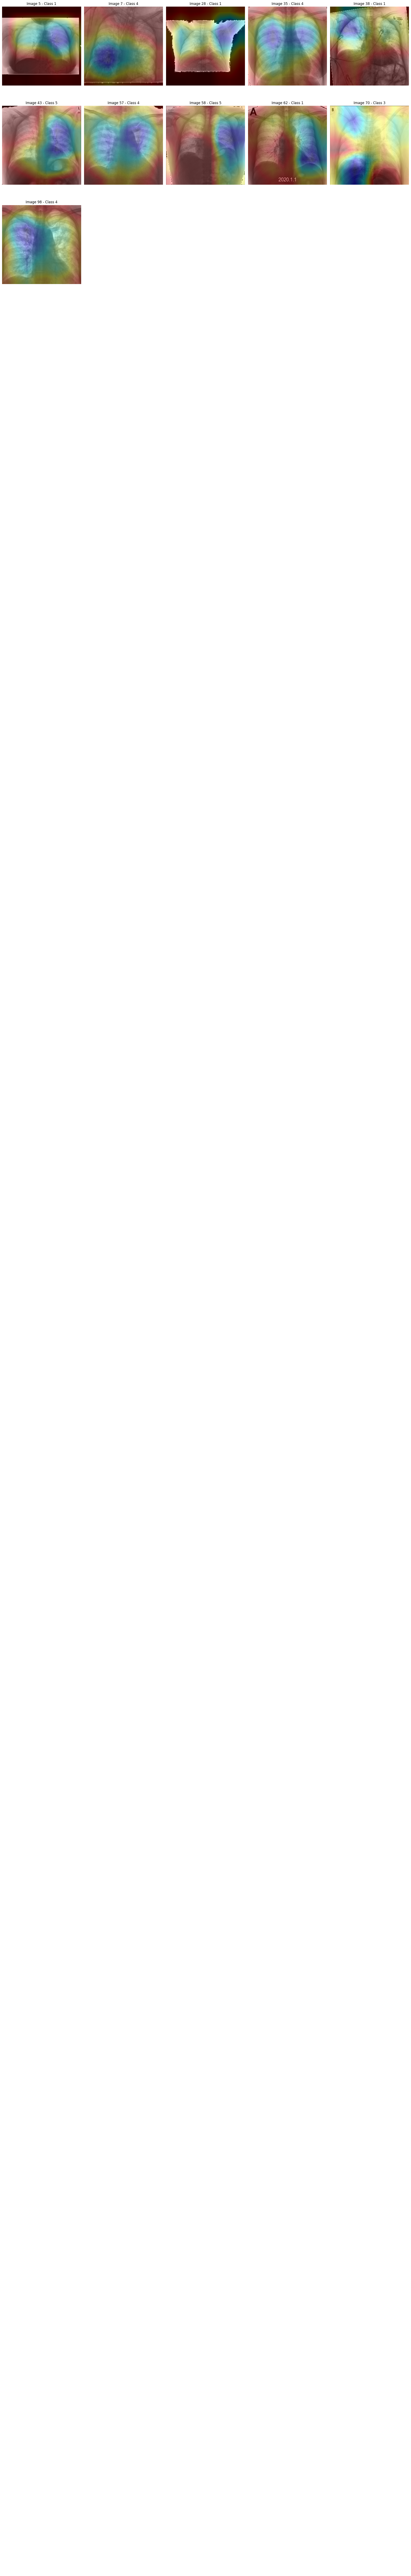

In [47]:

fig, axis = plt.subplots(26, 5, figsize=(20, 125))

for i, ax in enumerate(axis.flat):
    if i < len(heatmap_output_1):
        ax.imshow(heatmap_output_1[i])
        ax.axis('off')
        ax.set_title(f"Image {image_id[i]} - Class {output_class[i]}")
    else:
        ax.axis('off')  # Hide unused axes

plt.tight_layout()
plt.show()

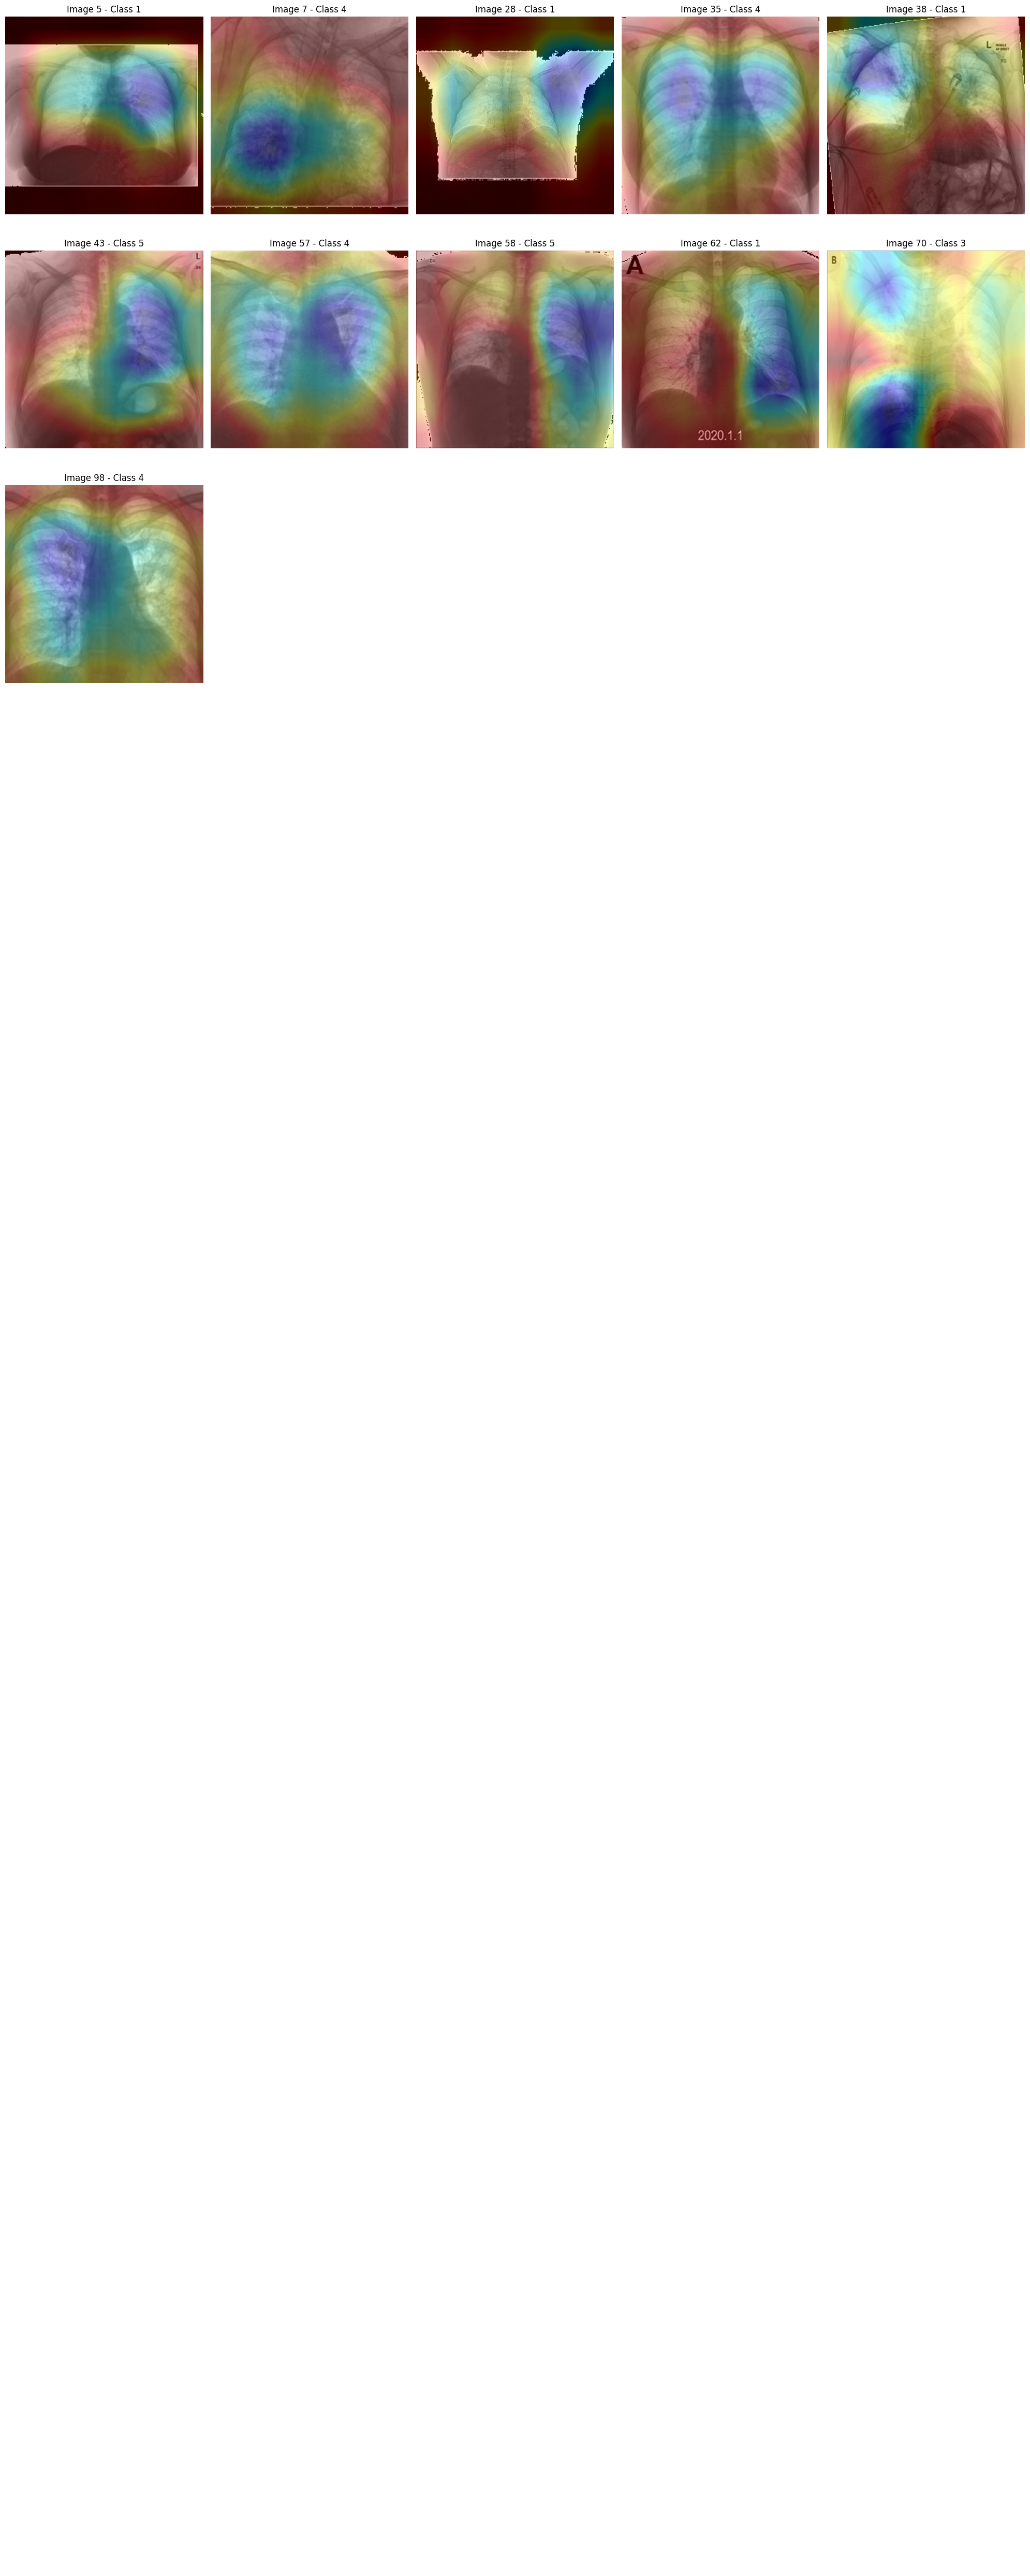

In [45]:
fig, axis = plt.subplots(11, 5, figsize=(20, 50))

for i, ax in enumerate(axis.flat):
    if i < len(heatmap_output_1):
        ax.imshow(heatmap_output_1[i])
        ax.axis('off')
        ax.set_title(f"Image {image_id[i]} - Class {output_class[i]}")
    else:
        ax.axis('off')  # Hide unused axes

plt.tight_layout()
plt.show()